# Run Sandwich Attacks on Swaps from the Public Mempool

In [3]:
%load_ext autoreload
%autoreload 2

In [31]:
import os
import sys
import math

current_path = sys.path[0]
sys.path.append(
    current_path[: current_path.find("defi-measurement")]
    + "liquidity-distribution-history"
)

sys.path.append("..")


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


from datetime import datetime, timezone


# Set display options
pd.set_option("display.max_colwidth", None)  # Display entire cell content
pd.set_option("display.max_rows", 50)  # Display all rows
pd.set_option("display.max_columns", None)  # Display all columns


from dotenv import load_dotenv
from pool_state import v3Pool
from sqlalchemy import create_engine
from tqdm import tqdm

load_dotenv(override=True)
# from experiments.random_permutations import load_pool

from experiments.preload_pool_cache import load_pool_from_blob
from experiments.calculate_simple_sandwich import (
    get_data,
    SwapData,
    single_sandwich_mev,
    max_frontrun,
    auto_sandwich_mev,
)


from decimal import getcontext

getcontext().prec = 100  # Set the precision high enough for our purposes


# Read in the environment variables
postgres_uri_mp = os.environ["POSTGRESQL_URI_MP"]
postgres_uri_us = os.environ["POSTGRESQL_URI_US"]
azure_storage_uri = os.environ["AZURE_STORAGE_CONNECTION_STRING"]

## Get the Data

### Populate the swap data we have with the block number that the swap appeared in

In [4]:
df = get_data()

df.head()

amountIn  \
pool                                       block_number                                                                                  
0x11b815efb8f581194ae79006d24e0d814b7697f6 17663582.0                                                              1000000000000000000   
                                           17663705.0                                                               550000000000000000   
                                           17664008.0    57896044618658097711785492504343953926634992332820282019728792003956564819968   
                                           17664143.0                                                              5003888921383035880   
                                           17664166.0    57896044618658097711785492504343953926634992332820282019728792003956564819968   

                                                        amountOutMin  \
pool                                       block_number                
0x11b815efb8f581194ae79006d24e0d814b7697f6 17663582.0     1853593534   
                                           17663705.0     1014298222   
                                           17664008.0     4871971661   
                                           17664143.0     9296674466   
                                           17664166.0     7218919681   

                                                                                             token0  \
pool                                       block_number                                               
0x11b815efb8f581194ae79006d24e0d814b7697f6 17663582.0    0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2   
                                           17663705.0    0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2   
                                           17664008.0    0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2   
                                           17664143.0    0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2   
                                           17664166.0    0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2   

                                                         fee  \
pool                                       block_number        
0x11b815efb8f581194ae79006d24e0d814b7697f6 17663582.0    500   
                                           17663705.0    500   
                                           17664008.0    500   
                                           17664143.0    500   
                                           17664166.0    500   

                                                                                             token1  \
pool                                       block_number                                               
0x11b815efb8f581194ae79006d24e0d814b7697f6 17663582.0    0xdac17f958d2ee523a2206206994597c13d831ec7   
                                           17663705.0    0xdac17f958d2ee523a2206206994597c13d831ec7   
                                           17664008.0    0xdac17f958d2ee523a2206206994597c13d831ec7   
                                           17664143.0    0xdac17f958d2ee523a2206206994597c13d831ec7   
                                           17664166.0    0xdac17f958d2ee523a2206206994597c13d831ec7   

                                                                                                                       hash  \
pool                                       block_number                                                                       
0x11b815efb8f581194ae79006d24e0d814b7697f6 17663582.0    0x4a2bbabb83084f8e296da188b818ce1a2f8c074e21afd9ce57cce4f81bbe368b   
                                           17663705.0    0x630017383a082d953bfd45833375addb200f2079b21249887d78e2ce40f5ada5   
                                           17664008.0    0x8e89c13331a3c3151ce620eb87d71da9d4907e33ccd47786d0200793de62785c   
                                           17664143.0    0x785722a78b734d9a6463f8162d961f208469920590de7ddea9b96937c4d9a296   

## Get a pool and do some initial testing

In [10]:
swap_data = df[df.hash == '0xa8dc098718e26494e7c0f541cd35fbed814059c6326e3381f481fe2423e209a7']

swap = SwapData(**swap_data.reset_index().to_dict('records')[0]) # type: ignore

swap

SwapData(pool='0x11b815efb8f581194ae79006d24e0d814b7697f6', block_number=17665590.0, amountIn='993550000', amountOutMin='508791592163898637', token0='0xdac17f958d2ee523a2206206994597c13d831ec7', fee='500', token1='0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2', hash='0xa8dc098718e26494e7c0f541cd35fbed814059c6326e3381f481fe2423e209a7', first_seen=Timestamp('2023-07-10 20:19:32.781000+0000', tz='UTC'))

In [7]:
pool = load_pool_from_blob(
    str(swap_data.index.get_level_values(0)[0]),
    postgres_uri_us,
    azure_storage_uri,
    "uniswap-v3-pool-cache",
    verbose=True,
    invalidate_before_date=datetime(2023, 8, 16, tzinfo=timezone.utc),
)

Loading pool from Azure blob storage cache


In [28]:
assert pool is not None

profit, gas, prices = single_sandwich_mev(
    pool,
    swap,
    int(6340608000000),
    pool_fee=True,
)

print(f"Profit: {profit}")
print(f"Gas: {gas}")
print(f"Prices: {prices}")

Profit: -6271838079
Gas: 0.007010483569918752
Prices: (4.3577930944809406e-05, 4.4177764460898176e-05, 4.4177862702853464e-05, 4.357825011449746e-05)


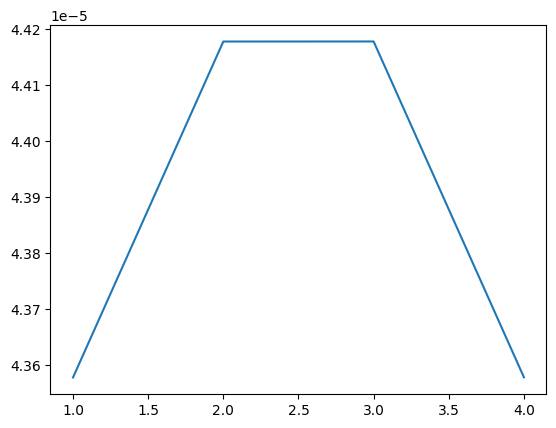

In [29]:
plt.plot([1,2,3,4], prices);

In [27]:
assert pool

max_frontrun(
    pool,
    swap,
    verbose=True,
)

0: Trying 1000000.0
1: Trying 2000000.0
2: Trying 4000000.0
3: Trying 8000000.0
4: Trying 16000000.0
5: Trying 32000000.0
6: Trying 64000000.0
7: Trying 128000000.0
8: Trying 256000000.0
9: Trying 512000000.0
10: Trying 1024000000.0
11: Trying 2048000000.0
12: Trying 4096000000.0
13: Trying 8192000000.0
14: Trying 16384000000.0
15: Trying 32768000000.0
16: Trying 65536000000.0
17: Trying 131072000000.0
18: Trying 262144000000.0
19: Trying 524288000000.0
20: Trying 1048576000000.0
21: Trying 2097152000000.0
22: Trying 4194304000000.0
23: Trying 8388608000000.0
0: Trying 4194304000000.0 - 8388608000000.0
1: Trying 6291456000000.0 - 8388608000000.0
2: Trying 6291456000000.0 - 7340032000000.0
3: Trying 6291456000000.0 - 6815744000000.0
4: Trying 6291456000000.0 - 6553600000000.0
5: Trying 6291456000000.0 - 6422528000000.0
6: Trying 6291456000000.0 - 6356992000000.0
7: Trying 6324224000000.0 - 6356992000000.0
8: Trying 6340608000000.0 - 6356992000000.0


6340608000000.0

In [40]:
assert pool is not None

auto_sandwich_mev(
    pool,
    swap,
    start=1e12,
    factor=10,
    pool_fee=True,
    verbose=True,
)

0: Trying 1000000.0
1: Trying 10000000.0
2: Trying 100000000.0
3: Trying 1000000000.0
4: Trying 10000000000.0
5: Trying 100000000000.0
6: Trying 1000000000000.0
7: Trying 10000000000000.0
0: Trying 1000000000000.0 - 10000000000000.0
1: Trying 5500000000000.0 - 10000000000000.0
2: Trying 5500000000000.0 - 7750000000000.0
3: Trying 5500000000000.0 - 6625000000000.0
4: Trying 6062500000000.0 - 6625000000000.0
5: Trying 6343750000000.0 - 6625000000000.0
6: Trying 6343750000000.0 - 6484375000000.0
7: Trying 6343750000000.0 - 6414062500000.0
8: Trying 6343750000000.0 - 6378906250000.0
9: Trying 6343750000000.0 - 6361328125000.0
10: Trying 6352539062500.0 - 6361328125000.0
11: Trying 6352539062500.0 - 6356933593750.0
12: Trying 6352539062500.0 - 6354736328125.0
13: Trying 6352539062500.0 - 6353637695312.0
14: Trying 6352539062500.0 - 6353088378906.0
15: Trying 6352813720703.0 - 6353088378906.0
16: Trying 6352951049804.0 - 6353088378906.0
17: Trying 6353019714355.0 - 6353088378906.0
18: Trying

AutoSandwichResult(profit=-6284193032.0, gas_fee=0.007010483569918752, frontrun_input=6353019714355.0, price_baseline=4.3577930944809406e-05, price_frontrun=4.4178991727856794e-05, price_user=4.417908996981208e-05, price_backrun=4.35782501103994e-05)

## Spurious calculations

In [ ]:
# Given 17 seconds per sandwich, how many sandwiches can you make in a night?
hours_per_night = 8
seconds_per_sandwich = 17
cpus = 1

hours_per_night * 60 * 60 / seconds_per_sandwich * cpus

1694.1176470588234